# Import Needed Librarys

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
from doub_dqn_agent import ddqn_agent
import pandas as pd

## Import env, brain, and explore state space

In [2]:
env = UnityEnvironment(file_name='Banana_Linux/Banana.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


Import our DQN agent and set up training code

In [6]:
st_size = len(env_info.vector_observations[0])
agent = ddqn_agent(state_size=st_size,action_size=brain.vector_action_space_size,seed=77)

In [7]:
#set path to save model results to. 
path = 'ddqn_sub/'


In [8]:
def ddqn(n_episodes = 2000, max_t = 1000, eps_start = 1, eps_end = 0.01, eps_decay = 0.995, path=path):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        path: location of folder to save model outputs and weights
    """
    scores = []
    score_window = deque(maxlen=100) #hold last 100 scores
    eps = eps_start                  #init eps
    
    for i_ep in range(1,n_episodes+1):
        score = 0
        #restart env 
        env_itter = env.reset(train_mode=True)[brain_name] #note training = True here
        #extract first state value
        state = env_itter.vector_observations[0]
        
        for t in range(max_t):
            
            action = agent.act(state, eps)
            #new env given action
            env_itter = env.step(action)[brain_name]
            new_state = env_itter.vector_observations[0]
            reward = env_itter.rewards[0]
            done = env_itter.local_done[0]
            #feed states/actions to the agent
            agent.step(state, action, reward,new_state, done)
            state = new_state
            score += reward
            
            if done:
                break
                
        score_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(score_window)), end="")
        if i_ep % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_ep, np.mean(score_window)))
            
            if np.mean(score_window)>=13:
                #Save weights once we have beat the environment 
                torch.save(agent.qnetwork_local.state_dict(), path + str(i_ep)+'checkpoint.pth')
                
    return scores

    
    

In [9]:
#train our agent!
scores = ddqn()



Episode 100	Average Score: 0.11
Episode 200	Average Score: 3.33
Episode 300	Average Score: 7.37
Episode 400	Average Score: 9.91
Episode 500	Average Score: 13.42
Episode 600	Average Score: 14.74
Episode 700	Average Score: 15.67
Episode 800	Average Score: 15.26
Episode 900	Average Score: 14.96
Episode 1000	Average Score: 15.31
Episode 1100	Average Score: 15.09
Episode 1200	Average Score: 14.30
Episode 1300	Average Score: 15.12
Episode 1400	Average Score: 15.50
Episode 1500	Average Score: 15.00
Episode 1600	Average Score: 14.39
Episode 1700	Average Score: 14.56
Episode 1800	Average Score: 15.63
Episode 1900	Average Score: 14.52
Episode 2000	Average Score: 14.49


In [12]:
#save scores out to import later if needed
pd.Series(scores,name='scores').to_csv(path+'scores.csv')

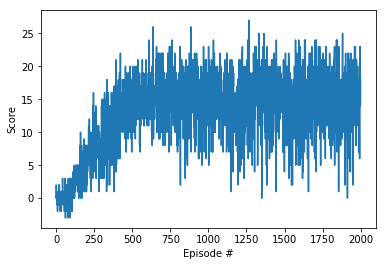

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig(path+'ddqn_score_graph.png')
plt.show()


In [16]:
#the training curve looks good!
#check what our max score is
max(scores)

29.0